# Übungszettel 8: Random Forests (Musterlösung)

## Maschinelles Lernen - WiSe 23/24

### Abgabe 20.12.2023, 23:55 Uhr

*Hinweise:*
- Übungsaufgaben **müssen** in Gruppen von 3-4 Personen abgegeben werden. **Einzelabgaben werden nicht korrigiert bzw. bewertet.**
- Es wird pro Übungszettel nur eine Aufgabe bewertet, die übrigen Aufgaben dienen zur selbstständigen Vertiefung des Vorlesungsstoffs. Für diese Aufgaben werden nach der Abgabe Musterlösungen bereitgestellt.
- Die Lösungen sollen in diesem IPython Notebook realisiert werden, wobei Teilaufgaben und Zwischenergebnisse ausgegeben bzw. visualisiert werden sollen.
- Für die Abgabe sollen Sie dieses IPython Notebook und ggf. zugehörige Dateien in ein **Ziparchiv** packen und im Ilias hochladen. Das Ziparchiv soll nach folgendem Muster benannt werden:
`UebungXX_Nachname1_Nachname2_Nachname3.zip`, wobei die Nachnamen in alphabetischer Reihenfolge angegeben und Umlaute ggf. ersetzt werden sollen. Bei Nichtbefolgung dieser Vorgabe können Punkte abgezogen werden.

---
## **Aufgabe 1: Random Forests (bewertet: 0,5+1+0,5+1+0,5+1+0,5 Punkte)**

a) Worin unterscheiden sich Bagging und Random Forests? 

Beim Bagging wird jedes Modell mit allen Features trainiert, bei Random Forests werden die Features, die für einen Split in Frage kommen sollen, zufällig gewählt. Beim Bagging müssen die Modelle nicht unbedingt Entscheidungsbäume sein. 

b) Erstellen Sie mit `sklearn` einen Random Forest in Python auf dem Datensatz `bank.csv`

Dieser stammt aus der Veröffentlichung S. Moro, P. Cortez and P.Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems (2014), doi:10.1016/j.dss.2014.03.001.). In der Datei `bank-info.txt` liegen Informationen zu den Attributen vor, `y` stellt die Zielvariable dar.

Nutzen Sie ein Trainings- und Testset. Bestimmen Sie den *out-of-bag-error* und den Fehler für den Testdatensatz.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("bank.csv", delimiter=";")

# dummify categorical variables (needed by RandomForestClassifier)
df = pd.get_dummies(df)

X = df.drop(["y_no", "y_yes"], axis=1)
y = df["y_yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

clf = RandomForestClassifier(oob_score=True)

In [7]:
clf.fit(X_train, y_train)
print("OOB error: {:f}\nTest set error: {:f}".format(1-clf.oob_score_, 1-clf.score(X_test, y_test)))

OOB error: 0.107364
Test set error: 0.104369


c) Was beschreibt der out-of-bag-error?

Um den Out-of-bag Fehler zu berechnen, werden für jeden Baum nur diejenigen Datensätze aus dem gesamten Trainingsdatensatz betrachtet, die nicht durch Bootstrapping zum Training desselben ausgewählt wurden, also nur die *out-of-bag-examples*. Unter allen Bäumen, die diesen Datensatz als *out-of-bag-example* haben, wird dieses per Mehrheitsentscheid klassifiziert. Der **Out-of-bag-error** ist nun der Anteil der falsch klassifizierten Out-of-bag-Datensätze and allen Out-of-bag-Datensätzen.

d) Bestimmen Sie den Mean Decrease of Gini zu allen Features und plotten Sie diesen.

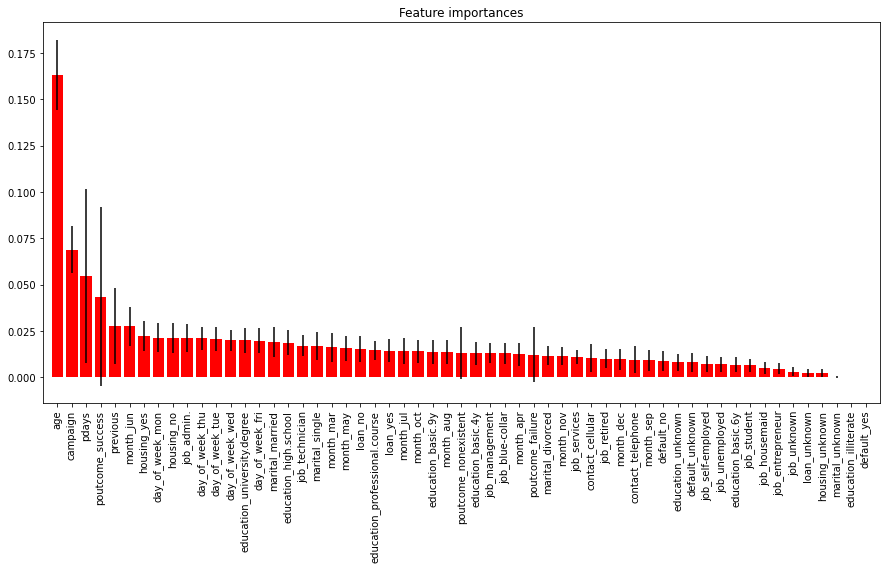

7 most important features:
1. age
2. campaign
3. pdays
4. poutcome_success
5. previous
6. month_jun
7. housing_yes


In [ ]:
%matplotlib inline

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,7))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), df.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

e) Nutzen Sie die sieben besten Attribute und erstellen Sie einen neuen Random Forest. 

In [9]:
top_features = []
print("7 most important features:")
for counter, index in enumerate(np.argsort(-importances)[:7]):
    print("{:d}. {:s}".format(counter + 1, df.columns[index]))
    top_features.append(df.columns[index])

In [9]:
X_train_top = X_train[top_features]
y_train_top = y_train

X_test_top = X_test[top_features]
y_test_top = y_test

clf_top = RandomForestClassifier(oob_score=True)
clf_top.fit(X_train_top, y_train_top)
print("OOB error: {:f}\nTest set error: {:f}".format(1-clf_top.oob_score_, 1-clf_top.score(X_test_top, y_test_top)))

OOB error: 0.114918
Test set error: 0.118932


f) Plotten Sie zu beiden Classifiern eine ROC Kurve und bestimmen Sie jeweils den AUC-Wert. 

In [10]:
scores = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, scores[:,1])
roc_auc = metrics.auc(fpr, tpr)

scores_top = clf_top.predict_proba(X_test_top)
fpr_top, tpr_top, thresholds_top = metrics.roc_curve(y_test.values, scores_top[:,1])
roc_auc_top = metrics.auc(fpr_top, tpr_top)

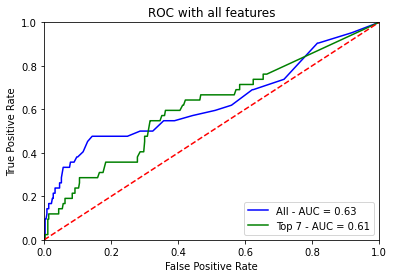

In [11]:
%matplotlib inline

plt.title('ROC with all features')
plt.plot(fpr, tpr, 'b', label = 'All - AUC = {:.2f}'.format(roc_auc))
plt.plot(fpr_top, tpr_top, 'g', label = 'Top 7 - AUC = {:.2f}'.format(roc_auc_top))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

g) Welcher Classifier liefert bessere Vorhersagen und warum? 

Die beiden Random Forest Klassifizierer sind in etwa gleich gut. Dies liegt daran, dass im zweiten Klassifizierer nur die weniger einflussreichen Features fehlen.
Bei der Verwendung eines Random Forests werden automatisch die besten Features am stärksten gewichtet. Für die Qualität der Vorhersagen des Random Forests bringt es also in der Regel nichts, weniger wichtige Features wegzulassen.

**ToDo: h) "Age" weglassen und neu berechnen. Bringt "Age" überhaupt etwas?**